<h1 align="center"> Protein Subcellular Localization Prediction

Protein subcellular localization prediction (or just protein localization prediction) involves the **prediction of where a protein resides in a cell, its subcellular localization.**

In general, prediction tools take as input information about a protein, such as a protein sequence of amino acids, and produce a predicted location within the cell as output, such as the nucleus, Endoplasmic reticulum, Golgi apparatus, extracellular space, or other organelles. The aim is to build tools that can accurately predict the outcome of protein targeting in cells.

**Prediction of protein subcellular localization is an important component of bioinformatics based prediction of protein function and genome annotation, and it can aid the identification of drug targets.**

<h2 align="center"> Data Explanation  <h2>

### columns
    

  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
      Binary attribute(0.48 or 1).
  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
	   Binary attribute(0.5 or 1).
  6.  aac: score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins.
  7. alm1: score of the ALOM membrane spanning region prediction program.
  8. alm2: score of ALOM program after excluding putative cleavable signal
	   regions from the sequence.

 Class Distribution
 
  cp  (cytoplasm) =                                      143
  
  im  (inner membrane without signal sequence) =        77         
  
  pp  (perisplasm)                             =       52
  
  imU (inner membrane, uncleavable signal sequence)  = 35
  
  om  (outer membrane)                            =    20
  
  omL (outer membrane lipoprotein)               =      5
  
  imL (inner membrane lipoprotein)              =       2

imS (inner membrane, cleavable signal sequence) =     2


<h1 align="center"> Program Start

### Load In Modules

In [1]:
#import modules
import pandas as pd
import numpy as np
import mglearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import  ExtraTreesClassifier
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


#ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#set show all columns
pd.set_option("display.max_columns",None)

#plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#disable warnings
import warnings
warnings.filterwarnings("ignore")

<br>
<br>
<br>
<br>

In [2]:
#reading in data
#creating dataframe
df = pd.read_csv('Bacteria_Data.txt', sep='\s+') #read in space delimited data
print('Dimensions: ' + str(df.shape))
df.head()

Dimensions: (336, 9)


,Sequence_Name,mcg,gvh,lip,chg,aac,alm1,alm2,Class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [3]:
#check class values
print(df.columns)
print(df.Class.value_counts())

Index(['Sequence_Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2',
       'Class'],
      dtype='object')
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: Class, dtype: int64


<br>
<br>
<br>
<br>

[]

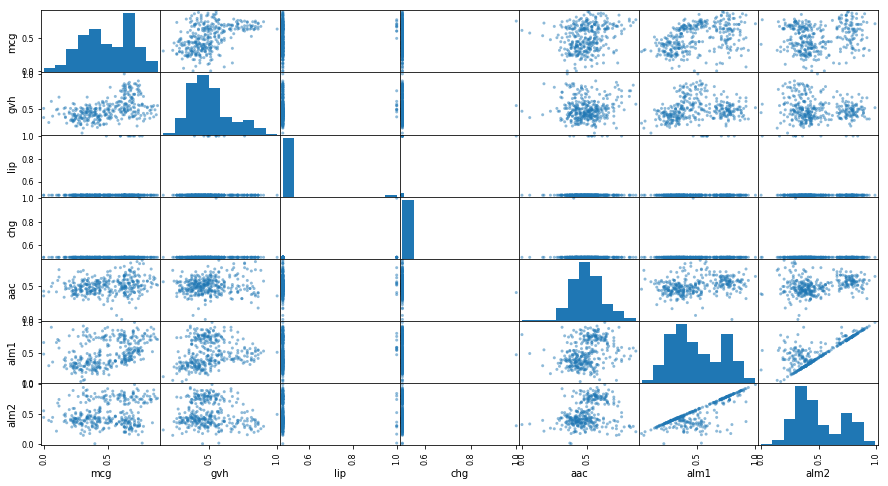

In [4]:
attributes = df.columns
scatter_matrix(df[attributes], figsize=(15,8))
plt.plot()

<br>
<br>
<br>
<br>

<h1 align="center"> 1. Binary Classification

-  To start off simple, predict whether the protein will be found in the cytoplasm or not

In [5]:
#generate new dataframe to be manipulated for Binary Classification
df_1 = df.copy()

In [6]:
#Create binary column
df_1['CP'] = np.where(df_1['Class']=='cp', 'yes','no')
df_1['CP'].value_counts()

no     193
yes    143
Name: CP, dtype: int64

In [7]:
df_1.head(3)

,Sequence_Name,mcg,gvh,lip,chg,aac,alm1,alm2,Class,CP
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp,yes
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp,yes
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp,yes


<br>
<br>
<br>
<br>

### Stratified Sampeling & Test/Train Split

In [8]:
#perform the stratified sampeling based on the binary response
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_1, df_1['CP']):
    strat_train_set = df_1.loc[train_index]
    strat_test_set = df_1.loc[test_index]
    
print('test:\n',strat_test_set['CP'].value_counts() / len(strat_test_set))
print('train:\n',strat_train_set['CP'].value_counts() / len(strat_train_set))

test:
 no     0.573529
yes    0.426471
Name: CP, dtype: float64
train:
 no     0.574627
yes    0.425373
Name: CP, dtype: float64


In [9]:
# Split into train/test set
from sklearn.model_selection import train_test_split

#Features
X_train = strat_train_set.drop(['CP','Class','Sequence_Name'], axis=1)

#response
y_train = strat_train_set['CP'].copy()

#Features
X_test = strat_test_set.drop(['CP','Class','Sequence_Name'], axis=1)

#response
y_test = strat_test_set['CP'].copy()

In [10]:
#Standardize Data
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<br>
<br>
<br>
<br>

### Run & Compare Algorithms

In [11]:
#import Algorithms
from sklearn.linear_model import LogisticRegression #logReg
from sklearn.naive_bayes import GaussianNB #NaiveB
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.svm import SVC #SVC
from sklearn.ensemble import BaggingClassifier #Bagging
from sklearn.neighbors import KNeighborsClassifier #Bagging
from sklearn.ensemble import AdaBoostClassifier #ADA
from sklearn.tree import DecisionTreeClassifier #ADA
from sklearn.ensemble import GradientBoostingClassifier #GB
from xgboost import XGBClassifier #XGBOOST
from sklearn.ensemble import VotingClassifier#VotingClassifier 

In [12]:
#Define Algorithms
log_clf = LogisticRegression(random_state=42, n_jobs=-1)
nb_clf = GaussianNB() 
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
svm_clf = SVC(random_state=42)
bagging_clf = BaggingClassifier(random_state=42, n_jobs=-1)
ada_clf = AdaBoostClassifier(random_state=42)
GB_clf = GradientBoostingClassifier(random_state=42)

XGB_clf = XGBClassifier(random_state=42, n_jobs=-1)

In [13]:
#voting calssifier of all algorithms
voting_clf = VotingClassifier(
    estimators =[('lr', log_clf),
                 ('nb', nb_clf),
                 ('rf', rnd_clf),
                 ('svc', svm_clf),
                ('bag', bagging_clf),
                ('ada', ada_clf),
                ('GB', GB_clf),
                ('XGB', XGB_clf)],
    
                    voting='hard')

In [14]:
#compare non-optimized Algorithms
for clf in (log_clf,
            nb_clf,
            rnd_clf,
            svm_clf,
            bagging_clf,
            ada_clf,
            GB_clf,
            XGB_clf,
            voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9117647058823529
GaussianNB 0.5
RandomForestClassifier 0.9117647058823529
SVC 0.9264705882352942
BaggingClassifier 0.8970588235294118
AdaBoostClassifier 0.8970588235294118
GradientBoostingClassifier 0.8970588235294118
XGBClassifier 0.8970588235294118
VotingClassifier 0.8970588235294118


-  **The only poor performer is Naive Bayes**

### Confusion Matrix

In [15]:
# creating a confusion matrix 
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted  no  yes
Actual            
no         34    5
yes         2   27


**Summary:** Binary Classification proved to be fairly accurate among classification algorithms. Other than Naieve Bayes, all algorithms were in the high 90's to perfect. Next step is to do a similar process for each location of protein within the cell. Imblanced classes will be considered moving forward.

<br>
<br>
<br>
<br>

<h2 align="center"> 2. Adasyn - Unbalanced Classes and Multiclass Classification

In [16]:
#create dataframe and look at value counts
df_2 = df.copy()
df_2 = df_2.dropna().reset_index()
df_2['Class'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: Class, dtype: int64

In [17]:
#omL imS imL, these classes are most likely too small for the model to learn anything
df_2 = df_2[df_2.Class != 'omL']
df_2 = df_2[df_2.Class != 'imS']
df_2 = df_2[df_2.Class != 'imL']
df_2['Class'].value_counts()


cp     143
im      77
pp      52
imU     35
om      20
Name: Class, dtype: int64

<br>
<br>
<br>
<br>

### Stratified Sampeling & Test/Train Split

In [18]:
#perform the stratified sampeling based on the binary response
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_2, df_2['Class']):
    strat_train_set = df_2.loc[train_index]
    strat_test_set = df_2.loc[test_index]

#dropna
strat_test_set = strat_test_set.dropna()
strat_train_set = strat_train_set.dropna()

#check percentges
print('test:\n',strat_test_set['Class'].value_counts() / len(strat_test_set))
print('train:\n',strat_train_set['Class'].value_counts() / len(strat_train_set))

# Split into train/test set
#Features
X_train = strat_train_set.drop(['Class','Sequence_Name'], axis=1)

#response
y_train = strat_train_set['Class'].copy()

#Features
X_test = strat_test_set.drop(['Class', 'Sequence_Name'], axis=1)

#response
y_test = strat_test_set['Class'].copy()

#Standardize Data
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# convert response columns to array
# y_train = y_train.values
# y_test = y_test.values

test:
 cp     0.460317
im     0.253968
pp     0.111111
imU    0.095238
om     0.079365
Name: Class, dtype: float64
train:
 cp     0.447059
im     0.239216
pp     0.141176
imU    0.113725
om     0.058824
Name: Class, dtype: float64


<br>
<br>
<br>
<br>

### Perform ADASYN

In [19]:
#Load in Adasyn
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

In [20]:
#Create synthetic training data
X_train_synthetic, y_train_synthetic = adasyn.fit_sample(X_train, y_train)

###### Compare Before/After Training Data

In [21]:
#compare

#DataFrame column name
columns = ["class"]

#Before Adasyn metrics
print("Before Adasyn\ny_train rows:",y_train.shape[0], "\ny_train rows:", y_train.shape[0])
print('\n',y_train.value_counts() / len(y_train))

#After adasyn metrics
print("\nAfter Adasyn")
print("y_train rows:",y_train_synthetic.shape[0], "\ny_train rows:", y_train_synthetic.shape[0])
print('\n',pd.DataFrame(y_train_synthetic, columns=columns)['class'].value_counts() / len(y_train_synthetic))

Before Adasyn
y_train rows: 255 
y_train rows: 255

 cp     0.447059
im     0.239216
pp     0.141176
imU    0.113725
om     0.058824
Name: Class, dtype: float64

After Adasyn
y_train rows: 571 
y_train rows: 571

 im     0.206655
om     0.199650
pp     0.199650
cp     0.199650
imU    0.194396
Name: class, dtype: float64


<br>
<br>
<br>
<br>

### Finding Best Performing Algorithm

In [22]:
for clf in (log_clf,
            nb_clf,
            rnd_clf,
            svm_clf,
            bagging_clf,
            ada_clf,
            GB_clf,
            XGB_clf,
            voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9047619047619048
GaussianNB 0.873015873015873
RandomForestClassifier 0.9682539682539683
SVC 0.9365079365079365
BaggingClassifier 1.0
AdaBoostClassifier 0.8253968253968254
GradientBoostingClassifier 1.0
XGBClassifier 0.9841269841269841
VotingClassifier 0.9841269841269841


In [23]:
rnd_clf = RandomForestClassifier(random_state=42, 
                                 n_jobs=-1,
                                 max_depth=8,
                                 n_estimators=10,
                                 max_features=5, 
                                 criterion='gini')

rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( accuracy_score(y_test, y_pred))

1.0


<br>
<br>
<br>
<br>

### Metrics for Multiclass Classification

In [24]:
# creating a confusion matrix 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          cp       1.00      1.00      1.00        29
          im       1.00      1.00      1.00        16
         imU       1.00      1.00      1.00         6
          om       1.00      1.00      1.00         5
          pp       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



<br>
<br>
<br>
<br>

### Cross-Validaiton Scores

In [25]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.1, train_size=.9, n_splits=10)
scores = cross_val_score(rnd_clf, X_train, y_train, cv=shuffle_split)
print("(trial #, Validation Scores)")
for i in enumerate(scores):
    print(i)

(trial #, Validation Scores)
(0, 1.0)
(1, 0.9615384615384616)
(2, 0.9615384615384616)
(3, 1.0)
(4, 1.0)
(5, 1.0)
(6, 1.0)
(7, 0.9615384615384616)
(8, 1.0)
(9, 1.0)
